# Исследование надежности заемщиков.

### Краткое описание

В данной работе проведена предварительная обработка и очистка данных (см.[Предобработка данных](#step_2)) , категоризация таких параметров, как цель дохода ([Категоризация дохода](#step_2.6)) и цель кредита ([Категоризация целей кредита](#step_2.7)), а так же получены ответы и сделаны предварительные выводы по ряду вопросов ([Ответы на вопросы.](#step_3))

### Оглавление

1. [Обзор данных](#step_1)
2. [Предобработка данных¶](#step_2)
    * [Проверка данных на аномалии и исправления](#step_2.2)
    * [Заполнение пропусков](#step_2.1)
    * [Изменение типов данных](#step_2.3)
    * [Удаление дубликатов](#step_2.4)
    * [Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма](#step_2.5)
    * [Категоризация дохода](#step_2.6)
    * [Категоризация целей кредита](#step_2.7)
3. [Ответы на вопросы.](#step_3)
    * [Вопрос 1: Есть ли зависимость между количеством детей и возвратом кредита в срок?](#step_3.1)
    * [Вопрос 2: Есть ли зависимость между семейным положением и возвратом кредита в срок?](#step_3.2)
    * [Вопрос 3: Есть ли зависимость между уровнем дохода и возвратом кредита в срок?](#step_3.3)
    * [Вопрос 4: Как разные цели кредита влияют на его возврат в срок?](#step_3.4)
4. [Общий вывод](#step_4)

<a id="step_1"></a>
### Шаг 1. Обзор данных 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os

In [2]:
pth = '/datasets/data.csv' 

if os.path.exists(pth):
    df = pd.read_csv(pth)
else:
    print('path to file is wrong')  
          
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


посмотрим на описательную статистику и заметим отрицательные значения в столбцах 'children' и 'days_employed'

In [4]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


в связи с чем, для корректного расчета медиан, сперва необходимо привести к адекватному значению. поэтому далее будет пункт не по порядку

<a id="step_2"></a>
## Шаг 2 Предобработка данных

<a id="step_2.2"></a>
### Шаг 2.2 Проверка данных на аномалии и исправления.

Итак, что мы видим:
1. в столбцах '*children*' и '*days_employed*' встречается отрицательное значение, что явно ошибка
2. значение 20 в столбце '*children*' вроде не то чтобы "ок".. будем "посмотреть"
3. в столбце 'dob_years' (возраст клиента в годах) - встречается 0, что так же не ок.
4. со столбцами *'education_id'*,	*'family_status_id'* и	*'debt'*	на первый взгляд вроде все порядке. значения лежат от 0 до 4 для *'education_id'* и	*'family_status_id'* и от 0 до 1 для *'debt'*
5. *'total_income'* отрицательных значений не принимает (и на том спасибо:)



Оценим масштабы трагедии по п.1-3 

In [5]:
# п.1 из шага 2.2 (подсчет количества)
print('число записей, где количество детей в семье < 0 составляет:' , len(df[df['children']<0]))
print('число записей, где общий трудовой стаж в днях < 0 составляет:' , len(df[df['days_employed']<0]))

число записей, где количество детей в семье < 0 составляет: 47
число записей, где общий трудовой стаж в днях < 0 составляет: 15906


посмотрим на этих "антиподов" (может просто они все из Австралии, кстати..)

In [6]:
# п.1 из шага 2.2 (просмотр фрагмента таблицы)
display(df[df['children']<0].head(2))
print('-'*40)
display(df[df['days_employed']<0].head(2))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,-4417.703588,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816.346412,профильное образование
705,-1,-902.084528,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882.899271,приобретение автомобиля


----------------------------------------


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля


выглядит как будто кто-то вбивал руками значения в строчку, а потом это как-то "странно" распарсилось. По хорошему бы уточнить с чем это могло бы быть связано, но имеем что имеем, поэтому тут видимо ничего не остается ничего, кроме как взять модуль от значения. Ну не удалять же из датасета в 21525 значений 15906 из них... очень похоже что знак "тире" как "минус" был воспринят. То же самое и про столбец 'children' видимо..


In [7]:
df[['children','days_employed']].describe()

,children,days_employed
count,21525.000000,19351.000000
mean,0.538908,63046.497661
std,1.381587,140827.311974
min,-1.000000,-18388.949901
25%,0.000000,-2747.423625
50%,0.000000,-1203.369529
75%,1.000000,-291.095954
max,20.000000,401755.400475


In [8]:
df['children'].value_counts().sort_values()

 5         9
 4        41
-1        47
 20       76
 3       330
 2      2055
 1      4818
 0     14149
Name: children, dtype: int64

In [9]:
# п.2 из шага 2.2
print('число записей, где количество детей в семье = 20 составляет:' , len(df[df['children']==20]))

число записей, где количество детей в семье = 20 составляет: 76


посмотрим что с возрастом в принципе. какие значения встречаются. (в данном случае и понятнее и наглядне будет barplot)

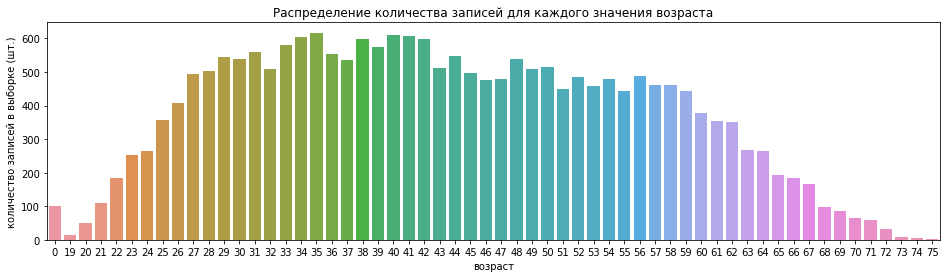

In [10]:
# п.3 из шага 2.2
ages = df['dob_years'].value_counts()
plt.figure(figsize=(16,4))
ax = sns.barplot(x=ages.index, y=ages)
ax.set(xlabel='возраст', ylabel='количество записей в выборке (шт.)')
ax.set_title("Распределение количества записей для каждого значения возраста")
plt.show()

In [11]:
print('а если точнее, то число записей, где "возраст клиента в годах" = 0 составляет:' , len(df[df['dob_years']==0]))

а если точнее, то число записей, где "возраст клиента в годах" = 0 составляет: 101


Принимаемся за исправления!

In [12]:
# п.1 из шага 2.2 - взятие модуля от числа
df_abs = df.copy() # в этот раз обойдемся без функции. просто создадим новую переменную где не будет отрицательных значений
df_abs['children'] = df['children'].abs()
df_abs['days_employed'] = df['days_employed'].abs()

Проверим как прошло преобразование

In [13]:
print('число записей, где количество детей в семье = -1 составляет:' , len(df_abs[df_abs['children']<0]))
print('число записей, где общий трудовой стаж в днях < 0 составляет:' , len(df_abs[df_abs['days_employed']<0]))

число записей, где количество детей в семье = -1 составляет: 0
число записей, где общий трудовой стаж в днях < 0 составляет: 0


Так же надо что-то сделать с 20 детьми и 0 лет. 
Решение что с этим делать - зависит от контекста. Если есть возможность перезапросить данные - надо опросить сделать корректную выгрузку (если не сам выгружаешь). 
Если есть только то, что есть и иного не будет, то надо смотреть на score модели в случае замены на медиану или при удалении записей. 
С учетом небольшого количества параметров и относительно небольшого количества невалидных записей, предварительно считаю что пока достаточно их дропнуть. Данные будут более честными, а для обучения модели оставшегося вполне хватит.
Итак:

In [14]:
# п.2,3 из шага 2.2 - исключение записей с 0 лет и 20 детей из датасета
df_abs_reduced = df_abs[df_abs['dob_years']!=0] 
df_abs_reduced = df_abs_reduced[df_abs_reduced['children']!=20]
print('количество записей, где возрост 0 лет:', len(df_abs_reduced[df_abs_reduced['dob_years']==0]))
print('количество записей, где 20 детей:', len(df_abs_reduced[df_abs_reduced['children']==20]))
print('текущее количество записей:', len(df_abs_reduced))

количество записей, где возрост 0 лет: 0
количество записей, где 20 детей: 0
текущее количество записей: 21349


отлично, идем дальше!

<a id="step_2.1"></a>
### Шаг 2.1 Заполнение пропусков

Посмотрим на датасет перед заполнением пропусков. Все столбцы кроме 'days_employed' и 'total_income' содержат по 21349 не пустых значений.
Столбцы 'days_employed' и 'total_income' содеражт по 19194.

In [15]:
df_abs_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21349 entries, 0 to 21524
Data columns (total 12 columns):
children            21349 non-null int64
days_employed       19194 non-null float64
dob_years           21349 non-null int64
education           21349 non-null object
education_id        21349 non-null int64
family_status       21349 non-null object
family_status_id    21349 non-null int64
gender              21349 non-null object
income_type         21349 non-null object
debt                21349 non-null int64
total_income        19194 non-null float64
purpose             21349 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


In [16]:
print('количество записей, где total_income не заполнен и при этом заполнен days_employed = ',
      len(df_abs_reduced[(df_abs_reduced['total_income'].isna()) & 
                         (~df_abs_reduced['days_employed'].isna())]
         )
     )

количество записей, где total_income не заполнен и при этом заполнен days_employed =  0


т.е., видимо, если не известен общий трудовой стаж (days_employed), то и ежемесячный доход является неизвестным значением, что логично если имеется ввиду средний ежемесячный доход, а не на текущем месте работы. 
С другой стороны, эти значения могут поступать из какого-то одного источника в котором по данному заемщику нет информации.
В любом случае выгляд как будто эти данные как-то между собой связаны (или через источник или через формулу)

посчитаем пропуски

In [17]:
proportion_of_total_missing_values = len(df_abs_reduced[df_abs_reduced['total_income'].isna()])/len(df_abs_reduced)
print(f'Доля пропусков от общего числа всех записей составляет {proportion_of_total_missing_values:.1%}')

Доля пропусков от общего числа всех записей составляет 10.1%


Заполним пропуски в полях 'total_income' и 'days_employed' медианным занченим. Попробуем заполнить с учетом 'income_type' и 'education_id', но посмотрим сперва на агрегатные значения при группировке по income_type и education_id

In [18]:
df_abs_reduced.groupby(by=['income_type','education_id'])['total_income'].agg(['median','mean','count']) #.sort_values( ascending=False)

median           mean  count
income_type     education_id                                     
безработный     0             202722.511368  202722.511368      1
                1              59956.991984   59956.991984      1
в декрете       1              53829.130729   53829.130729      1
госслужащий     0             172511.107016  197612.178874    484
                1             136803.501484  154016.630639    768
                2             160592.345303  172476.953367     46
                3             148339.290825  184056.353037      6
                4             111392.231107  111392.231107      1
компаньон       0             201785.400018  242783.907490   1584
                1             159070.690289  179582.781409   2667
                2             179937.527982  197896.757732    260
                3             136798.905143  165057.030695     29
пенсионер       0             144240.768611  170827.674567    516
                1             114825.442148  131698.963945   2773
                2             120136.896353  138312.108423     35
                3             102598.653164  111314.924441     93
                4             177088.845999  177088.845999      2
предприниматель 0             499163.144947  499163.144947      1
сотрудник       0             166006.067124  191797.946100   2086
                1             136525.031056  152589.186769   7373
                2             151625.779994  174750.744232    330
                3             125994.910603  137212.850187    133
                4             198570.757322  194310.337215      3
студент         0              98201.625314   98201.625314      1

как видно, некоторые сочетания в датасете отсутствуют (например income_type = 'безработный' и education_id = 2). 
Некотороые сочетания встречаются по одному разу (что, конечно может не отражатть выборку с фильтрацией по данным параметрам)
Но в целом при группировке по данным столбцам видно, что "медиана" и "среднее" отличаются. 
Поэтому будем заполнять проспуски медианным значеним с учетом значений 'income_type' и 'education_id'

In [19]:
def change_nan_to_median(df:pd.DataFrame, columns_list:list)->pd.DataFrame:
    """
    Данная функция принимает на вход датафрейм и список столбцов. Далее функция:
    1. Для каждого столбца группирует датасет в цикле  по всем возможным сочетаниям значений столбцов 'income_type' и 'education_id'
    2. Заполняет в сгруппированной выборке пропущенные значения медианным значением
    """
    df_local = df.copy()
    for column in columns_list:
        for current_income_type in df_local['income_type'].unique().tolist():
            for current_education_id in df_local['education_id'].unique().tolist():
                try:
                    med = df_local[(df_local['education_id']==current_education_id) & (df_local['income_type']==current_income_type)]\
                    .groupby(by=['income_type','education_id'])['total_income'].median()[0]
                    df_local.loc[(df_local['education_id']==current_education_id) & (df_local['income_type']==current_income_type),column] = df_local.loc[(df_local['education_id']==current_education_id) & (df_local['income_type']==current_income_type), column].fillna(med)
                except Exception as e:
                    print(f'для column = {column},current_income_type = {current_income_type},current_education_id = {current_education_id} ошибка {e}')
    return df_local

In [20]:
columns_list = ['total_income','days_employed']
df_wo_nan = change_nan_to_median(df_abs_reduced, columns_list) 

для column = total_income,current_income_type = компаньон,current_education_id = 4 ошибка index out of bounds
для column = total_income,current_income_type = безработный,current_education_id = 2 ошибка index out of bounds
для column = total_income,current_income_type = безработный,current_education_id = 3 ошибка index out of bounds
для column = total_income,current_income_type = безработный,current_education_id = 4 ошибка index out of bounds
для column = total_income,current_income_type = предприниматель,current_education_id = 1 ошибка index out of bounds
для column = total_income,current_income_type = предприниматель,current_education_id = 2 ошибка index out of bounds
для column = total_income,current_income_type = предприниматель,current_education_id = 3 ошибка index out of bounds
для column = total_income,current_income_type = предприниматель,current_education_id = 4 ошибка index out of bounds
для column = total_income,current_income_type = студент,current_education_id = 1 ошибка in

In [21]:
# проверим как прошло преобразование
print(f'количество пропусков в столбце \'total_income\' = ', len(df_wo_nan[df_wo_nan['total_income'].isna()]))
print(f'количество пропусков в столбце \'days_employed\' = ', len(df_wo_nan[df_wo_nan['days_employed'].isna()]))

количество пропусков в столбце 'total_income' =  0
количество пропусков в столбце 'days_employed' =  0


In [22]:
# просто info() на всякий случай
df_wo_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21349 entries, 0 to 21524
Data columns (total 12 columns):
children            21349 non-null int64
days_employed       21349 non-null float64
dob_years           21349 non-null int64
education           21349 non-null object
education_id        21349 non-null int64
family_status       21349 non-null object
family_status_id    21349 non-null int64
gender              21349 non-null object
income_type         21349 non-null object
debt                21349 non-null int64
total_income        21349 non-null float64
purpose             21349 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


С пропусками разобрались.

Ответим на вопрос "**почему заполнить пропуски медианным значением — лучшее решение для количественных переменных**" 

Вообще говоря  хороший вопрос. Ответа в теории курса я на него не получил, но искал. До модуля про статистику, думаю рановато спрашивать. Но предполагаю, что ответ примерно такой: 
1. "Среднее" чувствительно к выбросам (хотя мы этого еще не проходили) поэтому как минимум без очистки от выбросов оно не подходит.
2. Мода могла бы подойти в случае нормального унимодального распределения (и это мы тоже не проходили), но т.к. мы не знаем какое распределение (а вдруг оно таковым не является) то остается вар.3
3. Медиана. 

Есть еще и всякая экзотика из матстата, но там надо хорошо понимать структуру данных. 
Ну а на практике думаю самый надежный варинат - это подбор характеристики опытным путем. Провести эксперимент и определить.

<a id="step_2.3"></a>
### Шаг 2.3. Изменение типов данных.

Заменим вещественный тип данных в столбце total_income и days_employed  на целочисленный

In [23]:
def mem_usage(pandas_obj):
    usage_b = pandas_obj.memory_usage(deep=True).sum()
    usage_mb = usage_b / 1024 ** 2 # преобразуем байты в мегабайты
    return "{:03.2f} MB".format(usage_mb)

In [24]:
df_wo_nan = df_wo_nan.copy()

df_wo_nan['total_income'] = df_wo_nan['total_income'].astype(int) 
df_wo_nan['days_employed'] = df_wo_nan['days_employed'].astype(int)     
mem_before = mem_usage(df_wo_nan)
print(mem_before)

11.75 MB


In [25]:
df_wo_nan_low_mem = df_wo_nan.copy()
df_wo_nan_low_mem['children'] = df_wo_nan_low_mem['children'].astype(np.int8)
df_wo_nan_low_mem['dob_years'] = df_wo_nan_low_mem['dob_years'].astype(np.int8)
df_wo_nan_low_mem['education_id'] = df_wo_nan_low_mem['education_id'].astype(np.int8)
df_wo_nan_low_mem['family_status_id'] = df_wo_nan_low_mem['family_status_id'].astype(np.int8)
df_wo_nan_low_mem['debt'] = df_wo_nan_low_mem['debt'].astype(np.int8) 
df_wo_nan_low_mem['family_status'] = df_wo_nan_low_mem['family_status'].astype('category')
df_wo_nan_low_mem['education'] = df_wo_nan_low_mem['education'].astype('category')
df_wo_nan_low_mem['total_income'] = df_wo_nan_low_mem['total_income'].astype(np.int32) 
df_wo_nan_low_mem['days_employed'] = df_wo_nan_low_mem['days_employed'].astype(np.int32)     
mem_after = mem_usage(df_wo_nan_low_mem)
print(mem_after)

6.65 MB


In [26]:
mem_before_int = float(mem_before.split(' ')[0])
mem_after_int = float(mem_after.split(' ')[0])
print('дополительно поработав с типами данных удалось сэкономить: {:.1%}'
      .format((mem_before_int - mem_after_int) /mem_before_int ))

дополительно поработав с типами данных удалось сэкономить: 43.4%


'total_income' и 'days_employed' преобразовался. порядок. идем дальше!

<a id="step_2.4"></a>
### Шаг 2.4. Удаление дубликатов.

Оценим количество дублей

In [27]:
print(f'из {len(df_wo_nan_low_mem)} записей, задублировано {df_wo_nan_low_mem.duplicated().sum()}:')

из 21349 записей, задублировано 54:


Дропнем дубли

In [28]:
df_wo_nan_droped = df_wo_nan_low_mem.drop_duplicates().reset_index(drop=True)
print(f'из {len(df_wo_nan)} записей, задублировано {df_wo_nan_droped.duplicated().sum()}:')

из 21349 записей, задублировано 0:


Отлично. 21349 - 21295 = 54. идем дальше!

посмотрим на неявные дубликаты

In [29]:
df_wo_nan_droped.groupby('education_id')['education'].apply(lambda x: list(set(','.join(x).split(',')))).reset_index()

,education_id,education
0,0,"[Высшее, высшее, ВЫСШЕЕ]"
1,1,"[среднее, Среднее, СРЕДНЕЕ]"
2,2,"[неоконченное высшее, НЕОКОНЧЕННОЕ ВЫСШЕЕ, Нео..."
3,3,"[начальное, Начальное, НАЧАЛЬНОЕ]"
4,4,"[ученая степень, УЧЕНАЯ СТЕПЕНЬ, Ученая степень]"


Тут явно присутствуют неявные дубликаты..

In [30]:
df_wo_nan_droped.groupby('family_status_id')['family_status'].apply(lambda x: list(set(','.join(x).split(',')))).reset_index()

,family_status_id,family_status
0,0,[женат / замужем]
1,1,[гражданский брак]
2,2,[вдовец / вдова]
3,3,[в разводе]
4,4,[Не женат / не замужем]


Зато тут они явно отсутствуют

как видно есть проблемы с регистром. Если привести 'education' к lower_case то неявные дубликаты уйдут.

так сделаем это!

In [31]:
df_wo_nan_droped['education'] = df_wo_nan_droped['education'].str.lower()

проверим

In [32]:
df_wo_nan_droped.groupby('education_id')['education'].apply(lambda x: list(set(','.join(x).split(',')))).reset_index()

,education_id,education
0,0,[высшее]
1,1,[среднее]
2,2,[неоконченное высшее]
3,3,[начальное]
4,4,[ученая степень]


отлично! сработало. идем дальше!

In [33]:
print('в датаесте присутствуют следующие типзначения поля \'income_type\':\n',sorted(df_wo_nan_droped['income_type'].unique()))

в датаесте присутствуют следующие типзначения поля 'income_type':
 ['безработный', 'в декрете', 'госслужащий', 'компаньон', 'пенсионер', 'предприниматель', 'сотрудник', 'студент']


In [34]:
print('в датаесте присутствуют следующие значения поля \'gender\' :\n', sorted(df_wo_nan_droped['gender'].unique()))

в датаесте присутствуют следующие значения поля 'gender' :
 ['F', 'M', 'XNA']


'XNA', конечно, странный пол, но видимо он неизвестен и пока просто будем это иеть ввиду, а не заменять на NaN (от которых мы избавлялись ранее)

In [35]:
print('в датаесте присутствуют следующие значения поля \'gender\' :\n', sorted(df_wo_nan_droped['purpose'].unique()))

в датаесте присутствуют следующие значения поля 'gender' :
 ['автомобили', 'автомобиль', 'высшее образование', 'дополнительное образование', 'жилье', 'заняться высшим образованием', 'заняться образованием', 'на покупку автомобиля', 'на покупку подержанного автомобиля', 'на покупку своего автомобиля', 'на проведение свадьбы', 'недвижимость', 'образование', 'операции с жильем', 'операции с коммерческой недвижимостью', 'операции с недвижимостью', 'операции со своей недвижимостью', 'покупка жилой недвижимости', 'покупка жилья', 'покупка жилья для сдачи', 'покупка жилья для семьи', 'покупка коммерческой недвижимости', 'покупка недвижимости', 'покупка своего жилья', 'получение высшего образования', 'получение дополнительного образования', 'получение образования', 'приобретение автомобиля', 'профильное образование', 'ремонт жилью', 'свадьба', 'свой автомобиль', 'сделка с автомобилем', 'сделка с подержанным автомобилем', 'строительство жилой недвижимости', 'строительство недвижимости', 'строит

тут кажется придется поработать, но об этом позже..

в заднии есть вопросы:
1. поясните, как выбирали метод для поиска и удаления дубликатов в данных;
2. приведите возможные причины появления дубликатов


ответы на них:

1.  Там где есть картегория и ее идентификатор, там логично сделать что-то наподобие как в MySQL GROUP_CONCAT(DISTINCT ) и посмотреть все возможные варианты. Можно конечно и через словарь было, но pandas хоть и с лябмбдой все же быстрее.

2. Там где нет идентификатора категории, там просто надо собрать все уникальные значения

3. Удаление явных дубликатов- ну тут вроде очвидно. есть метод в пандасе. Можно конечно посмотреть на записи где различие только в одном столцбе, в двух и т.д. но это явно в данном случае из серии оверинжиниринга

4. Неявные дубликаты где отличие в регистре удалять не стоит, достаточно просто все привести к lower_case

5. причина дубликатов в данном случае думаю одна - ручной ввод. хотя тогда могли бы быть и синтаксические ошибки, но думаю их нет потому что, учебное задание. 


<a id="step_2.5"></a>
### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

In [36]:
education_dict = df_wo_nan_droped[['education_id','education']].drop_duplicates().reset_index(drop=True)
display(education_dict)
family_status_dict = df_wo_nan_droped[['family_status_id','family_status']].drop_duplicates().reset_index(drop=True)
display(family_status_dict)

,education_id,education
0,0,высшее
1,1,среднее
2,2,неоконченное высшее
3,3,начальное
4,4,ученая степень


,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,Не женат / не замужем


Удалим из исходного датафрейма столбцы 'education' и 'family_status'

In [37]:
df_wo_nan_droped_2 = df_wo_nan_droped.drop(['education','family_status'], axis = 1)
print('проверим, дропнулись ли столбцы \'education\',\'family_status\' и выведем список столбцов:\n', df_wo_nan_droped_2.columns)

проверим, дропнулись ли столбцы 'education','family_status' и выведем список столбцов:
 Index(['children', 'days_employed', 'dob_years', 'education_id',
       'family_status_id', 'gender', 'income_type', 'debt', 'total_income',
       'purpose'],
      dtype='object')


словари созданы, из исходника столбцы дропнулись. едем дальше!

<a id="step_2.6"></a>
### Шаг 2.6. Категоризация дохода.

In [38]:
def income_categorizer(income):
    if income <= 30000:
        return 'E'
    if income <= 50000:
        return 'D'
    if income <= 200000:
        return 'C'
    if income <= 1000000:
        return 'B'
    return 'A'

df_wo_nan_droped['total_income_category'] = df_wo_nan_droped['total_income'].apply(income_categorizer)

In [39]:
df_wo_nan_droped['total_income'].describe()

count    2.129500e+04
mean     1.654669e+05
std      9.843444e+04
min      2.066700e+04
25%      1.075685e+05
50%      1.435950e+05
75%      1.982345e+05
max      2.265604e+06
Name: total_income, dtype: float64

In [40]:
# выборочно проверим 
display(df_wo_nan_droped.loc[(df_wo_nan_droped['total_income']<=30000),['total_income_category','total_income']].head(2))

display(df_wo_nan_droped.loc[(df_wo_nan_droped['total_income']>30000) & 
                             (df_wo_nan_droped['total_income']<=50000),['total_income_category','total_income']].head(2))

display(df_wo_nan_droped.loc[(df_wo_nan_droped['total_income']>50000) & 
                             (df_wo_nan_droped['total_income']<=200000),['total_income_category','total_income']].head(2))

display(df_wo_nan_droped.loc[(df_wo_nan_droped['total_income']>200000) & 
                             (df_wo_nan_droped['total_income']<=1000000),['total_income_category','total_income']].head(2))

display(df_wo_nan_droped.loc[(df_wo_nan_droped['total_income']>1000000),['total_income_category','total_income']].head(2))

,total_income_category,total_income
928,E,29426
1174,E,29749


,total_income_category,total_income
49,D,44591
71,D,43929


,total_income_category,total_income
1,C,112080
2,C,145885


,total_income_category,total_income
0,B,253875
3,B,267628


,total_income_category,total_income
1579,A,1089120
2210,A,1278622


функция работает. категории созданы. едем дальше!

<a id="step_2.7"></a>
### Шаг 2.7. Категоризация целей кредита.

In [41]:
def purpose_categorizer(purpose):
    if 'автомобил' in purpose:
        return 'операции с автомобилем'
    if 'образован' in purpose:
        return 'получение образования'
    if 'жиль' in purpose or 'недвижим' in purpose:
        return 'операции с недвижимостью'
    if 'свадьб' in purpose:
        return 'проведение свадьбы'
    return 'не определено'
    
df_wo_nan_droped['purpose_category'] = df_wo_nan_droped['purpose'].apply(purpose_categorizer)

In [42]:
# проверим преобразование
display(df_wo_nan_droped.groupby('purpose_category')['purpose_category'].count().sort_values())
display(df_wo_nan_droped[['purpose','purpose_category']].head())

purpose_category
проведение свадьбы           2312
получение образования        3981
операции с автомобилем       4271
операции с недвижимостью    10731
Name: purpose_category, dtype: int64

,purpose,purpose_category
0,покупка жилья,операции с недвижимостью
1,приобретение автомобиля,операции с автомобилем
2,покупка жилья,операции с недвижимостью
3,дополнительное образование,получение образования
4,сыграть свадьбу,проведение свадьбы


функция работает. категории созданы. едем дальше!

In [43]:
df_wo_nan_droped.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,B,операции с недвижимостью
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,C,операции с автомобилем
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,C,операции с недвижимостью
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,B,получение образования
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,C,проведение свадьбы


<a id="step_3"></a>
### Ответы на вопросы.

<a id="step_3.1"></a>
##### Вопрос 1: Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [44]:
# решение 1
for children_amount in sorted(df_wo_nan_droped['children'].unique().tolist()):
    amount_of_debt_with_chlidren = len(df_wo_nan_droped[(df_wo_nan_droped['children']==children_amount) & (df_wo_nan_droped['debt']==1)]) 
    amount_of_debt_without_chlidren = len(df_wo_nan_droped[(df_wo_nan_droped['children']==children_amount) & (df_wo_nan_droped['debt']==0)])
    share = amount_of_debt_with_chlidren /(amount_of_debt_with_chlidren + amount_of_debt_without_chlidren)
    print(f'доля тех должников у кого {children_amount} детей от общего числа тех, у кого {children_amount} детей: {share:.1%}')

доля тех должников у кого 0 детей от общего числа тех, у кого 0 детей: 7.5%
доля тех должников у кого 1 детей от общего числа тех, у кого 1 детей: 9.1%
доля тех должников у кого 2 детей от общего числа тех, у кого 2 детей: 9.5%
доля тех должников у кого 3 детей от общего числа тех, у кого 3 детей: 8.2%
доля тех должников у кого 4 детей от общего числа тех, у кого 4 детей: 9.8%
доля тех должников у кого 5 детей от общего числа тех, у кого 5 детей: 0.0%


In [45]:
# вариант решения 2. тот же ответ
df_wo_nan_droped.groupby('children')['debt'].agg(['mean','std', 'count']).sort_values('children').reset_index()

,children,mean,std,count
0,0,0.075367,0.263992,14038
1,1,0.091322,0.288097,4840
2,2,0.095145,0.293487,2039
3,3,0.082317,0.275267,328
4,4,0.097561,0.300406,41
5,5,0.000000,0.000000,9


##### Вывод 1:

1. Тема обширная и решать ее надо статистическими методами, а их еще не проходили
2. Рост среднего количества должников с увеличением коли-ва детей в целом наблюдается (за исключением значения 3 и 5)
2.1. При количестве 5 - выборка явно не репрезентативная, т.к. количество наблюдений мало, но возможно есть какая то в т.ч. скрытая закономерность (например с 5 детьми люди в целом реже берут кредиты)
2.2 При оценке необходимо учитывать статистическую значимость. Для этого сделал расчет стандартного отклонения, но сейчас это за рамками темы модуля, так что просто пока это имеем ввиду

<a id="step_3.2"></a>
##### Вопрос 2: Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [46]:
# решим задачу проверенным однострочником
df_wo_nan_droped.groupby('family_status')['debt'].agg(['mean','std', 'count']).sort_values('mean').reset_index()

,family_status,mean,std,count
0,вдовец / вдова,0.065263,0.247120,950
1,в разводе,0.071006,0.256943,1183
2,женат / замужем,0.075447,0.264122,12247
3,гражданский брак,0.092736,0.290097,4130
4,Не женат / не замужем,0.097666,0.296916,2785


##### Вывод 2:

1. Самые ненадежные - холостые и "почти" холостые 
2. Самые надежные у кого брак уже был (по той или иной причине)
3. Те кто в браке - посередине

<a id="step_3.3"></a>
##### Вопрос 3: Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [47]:
# решим задачу проверенным однострочником
df_wo_nan_droped.groupby('total_income_category')['debt'].agg(['mean','std', 'count']).sort_values('mean').reset_index()

,total_income_category,mean,std,count
0,D,0.060345,0.238467,348
1,B,0.069691,0.254650,5180
2,A,0.080000,0.276887,25
3,C,0.085178,0.279155,15720
4,E,0.090909,0.294245,22


##### Вывод 3:

1. Судя по категориям, зависимости не наблюдается
2. Возможно данный вопрос требует дополнительного изучения другими методами (которые еще не проходили)

<a id="step_3.4"></a>
##### Вопрос 4: Как разные цели кредита влияют на его возврат в срок?

In [48]:
# решим задачу проверенным однострочником
df_wo_nan_droped.groupby('purpose_category')['debt'].agg(['mean','std', 'count']).sort_values('mean').reset_index()

,purpose_category,mean,std,count
0,операции с недвижимостью,0.072407,0.259173,10731
1,проведение свадьбы,0.078287,0.268681,2312
2,получение образования,0.092690,0.290034,3981
3,операции с автомобилем,0.093187,0.290728,4271


##### Вывод 4:

1. Операции с недвижимостью и затем свадьбы - самые надежные (вероятно некоторые во время медового месяца пересматривают свои планы на жизнь..)
2. Операции с автомобилем - самые ненадежные.

<a id="step_4"></a>
## Общий вывод:

В процессе работы над данным проектом выполнена предобработка данных (проверка на аномалии и исправление, удаление и замена пропусков, удаление дубликатов), категоризованы статьи дохода и целей кредита и сделаны предварительные выводы о вероятности возврата кредита в срок в зависимости от попадании заемщика в различные категории: 
1. Рост среднего количества должников с увеличением количества детей в целом наблюдается
2. Самые ненадежные - холостые или в гражданском браке, самые надежные - у кого брак в прошлом.
3. Между уровнем дохода и вероятностью стать должником закономерности предварительно не наблюдается. 
4. Выявили наиболее и наименее рисковые категории цели кредитов. 

**Выводы:**

1. Похоже что датасет несколько доработан до того чтобы стать учебным (сделана предварительная поготовка, чтоб было проще категоризовать и т.д. , изменены доходы (вероятно домножено на какой-то нелинейный коэффицинт)
2. Где использовать pivot_table не очень понял, буду благодарен за комментарий/подсказку где бы он тут пригодился (после какого шага), но думаю принцип Оккама тут вполне можно применить: Зачем их делать, если можно без них... ну разве что в тренировочных целях..))
3. Достаточно много времени съела перетосовка кода и комментариев когда понял, что сперва бы все же модуль взять, а потом уже медиану высчитывать.. тут вопрос: это было намеренно сделано чтоб заполнилось или случайно? 
4. Текстовые комментарии  тоже съедают много времени. Насколько они избыточны/полны/не полны ? Можно ли сократить их или такой объем - норм?